## 필요한 모듈 설치 확인

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random
import os
import pickle
import time
from tqdm import tqdm_notebook
from collections import deque
from replay_memory import ReplayBuffer, SilPrioritizedReplayBuffer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from wrappers import wrap, wrap_cover, SubprocVecEnv

## 하이퍼 파라미터 정의하기

In [2]:
'''SAC Settings'''
# coefficient of entropy regularization
ENT_COEF = 1e-2
# experience replay memory size
MEMORY_CAPACITY = 10**6
# learn start
LEARN_START = int(1e+3)
# learn frequency
LEARN_FREQ = 1

'''Environment Settings'''
# sequential images to define state
STATE_LEN = 4
# openai gym env name
ENV_NAME = 'BreakoutNoFrameskip-v4'
# number of environments for SAC
N_ENVS = 4
# define gym 
env = SubprocVecEnv([wrap_cover(ENV_NAME) for i in range(N_ENVS)])
# check gym setting
N_ACTIONS = env.action_space.n;print('N_ACTIONS : ',N_ACTIONS) #  4
N_STATES = env.observation_space.shape;print('N_STATES : ',N_STATES) # (4, 84, 84)
# Total simulation step
N_STEP = 10**7
# gamma for MDP
GAMMA = 0.99
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE = 32
# learning rage
LR = 1e-4
# clip gradient
MAX_GRAD_NORM = 0.1

'''Save&Load Settings'''
# log frequency
LOG_FREQ = int(1e+3)
# check save/load
SAVE = True
LOAD = False
# paths for predction net, target net, result log
ACTOR_PATH = './data/model/sil_actor_net.pkl'
CRITIC_PATH = './data/model/sil_critic_net.pkl'
ACTION_CRITIC_PATH = './data/model/sil_action_critic_net.pkl'

/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Plea

N_ACTIONS :  4
N_STATES :  (4, 84, 84)
USE GPU: True


/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'w

## 네트워크 구조 정의하기

In [3]:
class ActorConvNet(nn.Module):
    def __init__(self):
        super(ActorConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 512)
        # actor
        self.actor = nn.Linear(512, N_ACTIONS)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        action_log_prob = F.log_softmax(self.actor(x), dim=1)

        return action_log_prob

    def save(self, PATH):
        torch.save(self.state_dict(),ACTOR_PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(ACTOR_PATH))
        
class CriticConvNet(nn.Module):
    def __init__(self):
        super(CriticConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 512)
        # actor
        self.critic = nn.Linear(512, 1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        value = self.critic(x)

        return value

    def save(self, PATH):
        torch.save(self.state_dict(),CRITIC_PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(CRITIC_PATH))
        
class ActionCriticConvNet(nn.Module):
    def __init__(self):
        super(ActionCriticConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 512)
        # actor
        self.action_critic = nn.Linear(512, N_ACTIONS)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        action_value = self.action_critic(x)

        return action_value

    def save(self, PATH):
        torch.save(self.state_dict(),ACTION_CRITIC_PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(ACTION_CRITIC_PATH))

## PPO 정의하기

In [4]:
# part of this code is based on original SIL code 
# https://github.com/junhyukoh/self-imitation-learning/blob/master/baselines/common/self_imitation.py
class SSAC:
    def __init__(self):
        self.actor_net = ActorConvNet()
        self.critic_net = CriticConvNet()
        self.critic_target = CriticConvNet()
        self.action_critic_net = ActionCriticConvNet()
        # use gpu
        if USE_GPU:
            self.actor_net = self.actor_net.cuda(device=3)
            self.critic_net = self.critic_net.cuda(device=3)
            # critic target network for stability
            self.critic_target = self.critic_net.cuda(device=3)
            self.action_critic_net = self.action_critic_net.cuda(device=3)
        
        # sync net and target
        self.critic_target.load_state_dict(self.critic_net.state_dict())
            
        # simulator step conter
        self.memory_counter = 0
        self.learn_step_counter = 0
        
        # create running episode memory
        self.running_episodes = [[] for _ in range(N_ENVS)]
        
        # Create the replay buffer
        self.replay_buffer = ReplayBuffer(MEMORY_CAPACITY)
        self.sil_buffer = SilPrioritizedReplayBuffer(MEMORY_CAPACITY, 0.6)
            
        # define optimizer
        self.actor_opt = torch.optim.Adam(self.actor_net.parameters(), lr=LR)
        self.critic_opt = torch.optim.Adam(self.critic_net.parameters(), lr=LR)
        self.action_critic_opt = torch.optim.Adam(self.action_critic_net.parameters(), lr=LR)
        
    def update_target(self, target, pred, update_rate):
        # update target network parameters using predcition network
        for target_param, pred_param in zip(target.parameters(), pred.parameters()):
            target_param.data.copy_((1.0 - update_rate) \
                                    * target_param.data + update_rate*pred_param.data)
        
    def save_model(self):
        self.actor_net.cpu()
        self.critic_net.cpu()
        self.action_critic_net.cpu()
        
        self.actor_net.save(ACTOR_PATH)
        self.critic_net.save(CRITIC_PATH)
        self.action_critic_net.save(ACTION_CRITIC_PATH)
        
        if USE_GPU:
            self.actor_net.cuda(device=3)
            self.critic_net.cuda(device=3)
            self.action_critic_net.cuda(device=3)
            
    def load_model(self):
        self.actor_net.cpu()
        self.critic_net.cpu()
        self.action_critic_net.cpu()
        
        self.actor_net.load(ACTOR_PATH)
        self.critic_net.load(CRITIC_PATH)
        self.action_critic_net.load(ACTION_CRITIC_PATH)
        
        if USE_GPU:
            self.actor_net.cuda(device=3)
            self.critic_net.cuda(device=3)
            self.action_critic_net.cuda(device=3)
        
    def choose_action(self, x):
        # Assume that x is a np.array of shape (nenvs, 4, 84, 84)
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda(device=3)
        # get action log probs and state values
        action_log_prob = self.actor_net(x)
        action_prob = F.softmax(action_log_prob, dim=1).data.cpu().numpy()
        # sample actions
        action = np.array([np.random.choice(N_ACTIONS,p=action_prob[i]) for i in range(len(action_prob))])
        return action
    
    def store_transition(self, s, a, r, s_, done):
        self.memory_counter += 1
        self.replay_buffer.add(s, a, r, s_, float(done))
        
    def sil_store_transition(self, s, a, r, done):
        # sil episode caching
        for n in range(N_ENVS):
            self.running_episodes[n].append([s[n], a[n], r[n]])

        for n, d in enumerate(done):
            if d:
                self.update_buffer(self.running_episodes[n])
                self.running_episodes[n] = []
                
    # SIL update buffer
    def update_buffer(self, trajectory):
        positive_reward = False
        for (ob, a, r) in trajectory:
            if r > 0:
                positive_reward = True
                break
        if positive_reward:
            self.add_episode(trajectory)
                
    def add_episode(self, trajectory):
        obs = []
        actions = []
        rewards = []
        dones = []
        
        for (ob, action, reward) in trajectory:
            obs.append(ob)
            actions.append(action)
            rewards.append(reward)
            dones.append(False)
        dones[len(dones)-1]=True
        returns = self.discount_with_dones(rewards, dones, GAMMA)
        for (ob, action, R) in list(zip(obs, actions, returns)):
            self.sil_buffer.add(ob, action, R)
            
    def discount_with_dones(self, rewards, dones, GAMMA):
        discounted = []
        r = 0
        for reward, done in zip(rewards[::-1], dones[::-1]):
            r = reward + GAMMA*r*(1.-done) # fixed off by one bug
            discounted.append(r)
        return discounted[::-1]

    def learn(self):
        self.learn_step_counter += 1

        # data sample from experience replay
        b_state_memory, b_action_memory, b_reward_memory, \
        b_next_state_memory, b_done = self.replay_buffer.sample(BATCH_SIZE)
        b_weights, b_idxes = np.ones_like(b_reward_memory), None

        b_s = torch.FloatTensor(b_state_memory)
        b_a = torch.LongTensor(b_action_memory)
        b_r = torch.FloatTensor(b_reward_memory)
        b_s_ = torch.FloatTensor(b_next_state_memory)
        b_d = torch.FloatTensor(b_done)

        if USE_GPU:
            b_s, b_a, b_r, b_s_, b_d = b_s.cuda(device=3), b_a.cuda(device=3), b_r.cuda(device=3), b_s_.cuda(device=3), b_d.cuda(device=3)

        # forward calc
        action_log_prob = self.actor_net(b_s)
        action_prob = F.softmax(action_log_prob, dim=1)
        action_log_prob = F.log_softmax(action_log_prob, dim=1)
        cur_value = self.critic_net(b_s).squeeze(1)
        next_value = self.critic_target(b_s_)
        action_value = self.action_critic_net(b_s)

        # critic loss. eq (5) in SAC paper
        value_target = (action_value - ENT_COEF * action_log_prob).gather(1, b_a.unsqueeze(1)).squeeze(1)
        critic_loss = 0.5 * F.smooth_l1_loss(cur_value, value_target.detach())

        # action critic loss. eq (7), (8) in SAC paper
        action_value_target = b_r + GAMMA * (1-b_d) * next_value.squeeze(1)
        action_critic_loss = 0.5 * F.smooth_l1_loss(action_value.gather(1, 
            b_a.unsqueeze(1)).squeeze(1), action_value_target.detach())

        # actor loss. eq (10) in SAC paper
        actor_loss = torch.mean(action_prob*(action_log_prob \
            - F.log_softmax(action_value.detach()/ENT_COEF, dim=1)))

        self.actor_opt.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_(self.actor_net.parameters(), MAX_GRAD_NORM)
        self.actor_opt.step()

        self.critic_opt.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.critic_net.parameters(), MAX_GRAD_NORM)
        self.critic_opt.step()

        self.action_critic_opt.zero_grad()
        action_critic_loss.backward()
        nn.utils.clip_grad_norm_(self.action_critic_net.parameters(), MAX_GRAD_NORM)
        self.action_critic_opt.step()

        self.update_target(self.critic_target, self.critic_net, 1e-3)

        # SIL update
        experience = self.sil_buffer.sample(BATCH_SIZE, beta=0)
        (sil_b_s, sil_b_a, sil_b_r, sil_b_weights, sil_b_idxes) = experience

        sil_b_s = torch.FloatTensor(sil_b_s)
        sil_b_a = torch.LongTensor(sil_b_a)
        sil_b_r = torch.FloatTensor(sil_b_r)
        sil_b_w = torch.Tensor(sil_b_weights)

        if USE_GPU:
            sil_b_s, sil_b_a, sil_b_r, sil_b_w = sil_b_s.cuda(device=3), sil_b_a.cuda(device=3), sil_b_r.cuda(device=3), sil_b_w.cuda(device=3)

        # forward calc
        sil_action_log_prob = self.actor_net(sil_b_s)
        sil_action_log_prob = F.log_softmax(sil_action_log_prob, dim=1)
        sil_cur_value = self.critic_net(sil_b_s).squeeze(1)
        sil_action_value = self.action_critic_net(sil_b_s)
        sil_adv = (torch.clamp(F.relu(sil_b_r - sil_cur_value), 0.0, 1.0)).data.cpu().numpy()

        # actor loss. eq (2) in SIL paper
        sil_actor_loss = torch.mean( sil_b_w * (-sil_action_log_prob.gather(1,
        sil_b_a.unsqueeze(1)).squeeze(1) * torch.clamp(F.relu(sil_b_r - sil_cur_value.detach()),0.0,1.0)))

        # critic loss. eq (3) in SIL paper
        sil_critic_loss = F.relu(sil_b_r - sil_cur_value)
        sil_critic_loss = 0.5 * torch.mean(sil_b_w * (F.smooth_l1_loss(sil_critic_loss,
        torch.zeros_like(sil_critic_loss), reduction='none')))
        
        # action critic_loss. this is not implemented in SIL paper
        sil_action_critic_loss = F.relu(sil_b_r \
                            - sil_action_value.gather(1, sil_b_a.unsqueeze(1)).squeeze(1))
        sil_action_critic_loss =0.5 * torch.mean(sil_b_w * \
                (F.smooth_l1_loss(sil_action_critic_loss, torch.zeros_like(sil_action_critic_loss)\
                , reduction='none')))

        self.actor_opt.zero_grad()
        sil_actor_loss.backward()
        nn.utils.clip_grad_norm_(self.actor_net.parameters(), MAX_GRAD_NORM)
        self.actor_opt.step()

        self.critic_opt.zero_grad()
        sil_critic_loss.backward()
        nn.utils.clip_grad_norm_(self.critic_net.parameters(), MAX_GRAD_NORM)
        self.critic_opt.step()
        
        self.action_critic_opt.zero_grad()
        sil_action_critic_loss.backward()
        nn.utils.clip_grad_norm_(self.action_critic_net.parameters(), MAX_GRAD_NORM)
        self.action_critic_opt.step()

        self.sil_buffer.update_priorities(sil_b_idxes, sil_adv)

        return round(float(actor_loss), 4), round(float(critic_loss), 4), round(float(action_critic_loss), 4)

## 학습

In [5]:
sac = SSAC()

# model load with check
if LOAD and os.path.isfile(PRED_PATH) and os.path.isfile(TARGET_PATH):
    sac.load_model()
    pkl_file = open(RESULT_PATH,'rb')
    result = pickle.load(pkl_file)
    pkl_file.close()
    print('Load complete!')
else:
    result = []
    print('Initialize results!')

print('Collecting experience...')

# episode step for accumulate reward 
epinfobuf = deque(maxlen=100)
# check learning time
start_time = time.time()

# env reset
s = np.array(env.reset())

for step in tqdm_notebook(range(1, N_STEP//N_ENVS + 1)):
    
    a = sac.choose_action(s)
    
    # take action and get next state
    s_, r, done, infos = env.step(a)
    s_ = np.array(s_)
    
    # log arrange
    for info in infos:
        maybeepinfo = info.get('episode')
        if maybeepinfo: epinfobuf.append(maybeepinfo)
            
    # store transition
    sac.sil_store_transition(s,a,r,done)
    for i in range(len(s_)):
        sac.store_transition(s[i],a[i],r[i],s_[i], done[i])
        
    if (step >= LEARN_START) and (step % LEARN_FREQ == 0):
        sac.learn()
        
    s = s_
            
    if step % LOG_FREQ == 0:
        # print log and save
        # check time interval
        time_interval = round(time.time() - start_time, 2)
        # calc mean return
        mean_100_ep_return = round(np.mean([epinfo['r'] for epinfo in epinfobuf]),2)
        result.append(mean_100_ep_return)
        # print epi log
        print('Used Step:',sac.memory_counter,
              '| Mean ep 100 return: ', mean_100_ep_return,
              '| Used Time:',time_interval)
        # save model
        if SAVE:
            sac.save_model()

Initialize results!


Used Step: 4000 | Mean ep 100 return:  1.7 | Used Time: 8.59
Used Step: 8000 | Mean ep 100 return:  1.52 | Used Time: 69.17
Used Step: 12000 | Mean ep 100 return:  1.61 | Used Time: 126.41
Used Step: 16000 | Mean ep 100 return:  1.82 | Used Time: 184.78
Used Step: 20000 | Mean ep 100 return:  1.75 | Used Time: 242.84
Used Step: 24000 | Mean ep 100 return:  1.96 | Used Time: 299.29
Used Step: 28000 | Mean ep 100 return:  2.21 | Used Time: 354.39
Used Step: 32000 | Mean ep 100 return:  2.53 | Used Time: 409.11
Used Step: 36000 | Mean ep 100 return:  3.08 | Used Time: 462.77
Used Step: 40000 | Mean ep 100 return:  3.54 | Used Time: 518.29
Used Step: 44000 | Mean ep 100 return:  4.07 | Used Time: 572.92
Used Step: 48000 | Mean ep 100 return:  4.63 | Used Time: 628.9
Used Step: 52000 | Mean ep 100 return:  5.45 | Used Time: 682.24
Used Step: 56000 | Mean ep 100 return:  6.07 | Used Time: 737.65
Used Step: 60000 | Mean ep 100 return:  6.56 | Used Time: 792.36
Used Step: 64000 | Mean ep 100 r

## 결과 시각화

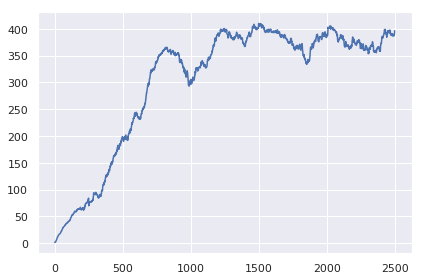

In [6]:
plt.plot(range(len(result)), result)
plt.tight_layout()
plt.show()

In [7]:
from matplotlib import animation

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('./ssac_breakout_result.gif', writer='imagemagick', fps=30)

/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total Reward : 413.00


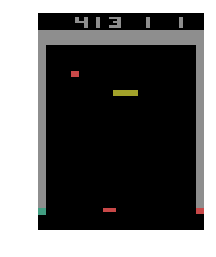

In [9]:
env = wrap(gym.make('BreakoutNoFrameskip-v4'))
s = np.array(env.reset())
total_reward = 0
frames = []
done_stack = 0

for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a = sac.choose_action(np.expand_dims(s,axis=0))
    # take action and get next state
    s_, r, done, info = env.step(a)
    s_ = np.array(s_)
    total_reward += r
    if done:
        done_stack += 1
        if done_stack == 5:
            break
    s = s_
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

![alt text](./ssac_pong_result.gif "segment")